In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from scipy.special import comb
import pymc3 as pm
import arviz as az
import random

# Problem 1

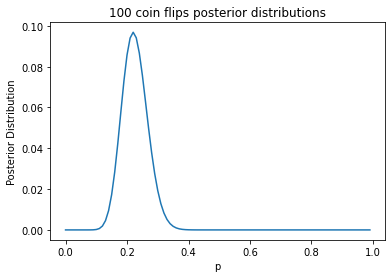

0.22

In [8]:
def binomial_pmf(n, k, p):
    return comb(n, k) * p**k *(1-p)**(n-k)

def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    # Draw from Binomial distribution and compute posterior distributions/integral
    draws = np.random.binomial(n, p)
    numers = [binomial_pmf(n, draws, i/100) for i in range(100)]
    denom = np.sum([binomial_pmf(n, draws, i/100) for i in range(100)])
    
    # plot
    points = [numer/denom for numer in numers]
    lin = np.linspace(0,.99, 100)
    plt.plot(lin, points)
    plt.title(str(n) + " coin flips posterior distributions")
    plt.xlabel("p")
    plt.ylabel("Posterior Distribution")
    plt.show()
    
    # return the MAP
    return np.argmax(numers) / (100)

bernoulli_sampling(.2, 100)


# Problem 2

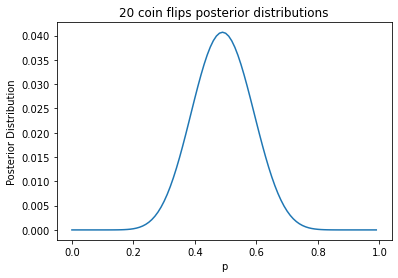

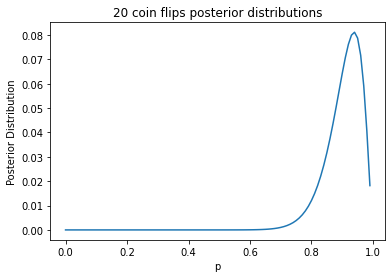

0.94

In [9]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    # Draw from Binomial distribution and compute posterior distributions/integral
    draws = np.random.binomial(n, p)
    numers = [binomial_pmf(n, draws, i/100) * prior.pdf(i/100) for i in range(100)]
    denom = np.sum([binomial_pmf(n, draws, i/100) * prior.pdf(i/100) for i in range(100)])
    
    # plot
    points = [numer/denom for numer in numers]
    lin = np.linspace(0,.99, 100)
    plt.plot(lin, points)
    plt.title(str(n) + " coin flips posterior distributions")
    plt.xlabel("p")
    plt.ylabel("Posterior Distribution")
    plt.show()
    
    # return the MAP
    return np.argmax(numers) / (100)
prior = beta(5,1.5)
non_uniform_prior(.4, 20, prior)
non_uniform_prior(.9, 20, prior)

# Problem 3

In [10]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    forecast = []
    idx_weather_dict = {0: 'sun', 1: 'rain', 2:'wind'}
    curr_idx = 0
    
    for _ in range(days):
        # Sample to get the next day
        next_day_idx = np.random.choice(3, 1, p=transition_matrix[curr_idx, :])[0]

        # keep track of the days and adjust the current state
        forecast.append(idx_weather_dict[next_day_idx])
        curr_idx = next_day_idx
    return forecast


In [17]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)
weather_forecast(transition_matrix, days=10)

['sun', 'wind', 'rain', 'wind', 'rain', 'rain', 'rain', 'sun', 'rain', 'rain']

# Problem 4

In [35]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    model = pm.Model()
    with model:
        theta = pm.Beta('theta', alpha=1., beta=1.)
        y = pm.Bernoulli('y', p=theta, observed=data)

        # Graph the trace
        trace = pm.sample(n) # n is the desired number of samples
        az.plot_trace(trace)

        # Calculate the mean
        theta = trace['theta']
        mean = theta.mean()
    return mean



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


0.3378686218067029


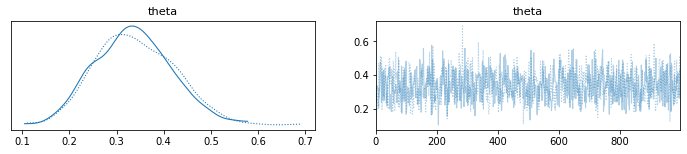

In [36]:
data = bernoulli.rvs(0.2, size=30)
avg = posterior_sampling(data, 1000)
print(avg)

# Problem 5

In [43]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    model = pm.Model()
    with model:
        # Initialize the pmc3
        mu = pm.Normal('mu', mu=m, sigma=s)
        tau = pm.Gamma('tau', alpha=alpha, beta=beta)
        y = pm.Normal('y', mu=mu, sigma=1/tau, observed=observed_heights)

        # Graph the trace
        trace = pm.sample(n) # n is the desired number of samples
        az.plot_trace(trace)
        plt.tight_layout()
        
        # Calculate mean
        mu = trace['mu']
        mean = mu.mean()
    return mean


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


178.71621812162124


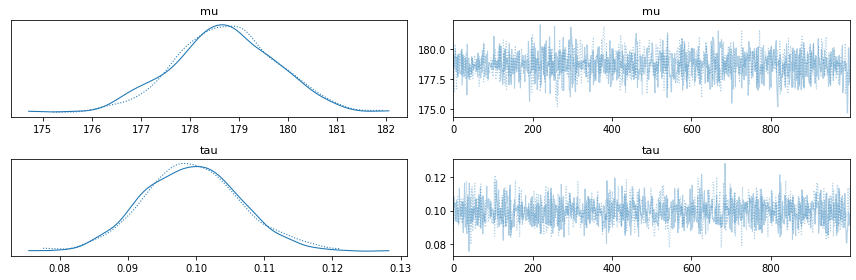

In [44]:
heights = np.random.normal(180,10,100)
avg = height_model(heights)
print(avg)